# Autoencoders in PyTorch

In this exercise we will experiment with different flavors of a powerful non-linear dimensionaly reduction tool called the autoencoder. The AE takes an input, feeds it into a neural network and tries to reconstruct the input back. By doing so, the autoencoder is able to find the salient features needed in order to reconstruct the input while minimizing the loss between the input and the reconstruction.

We will again use the MNIST dataset. However, this time we will only use the images, since the autoencoder has no use for the labels.

Start by doing the following:
1. Choose your hyperparameters: batch size (64-128), the number of epochs (<10) and the learning rate. 
<br><br>
2. Create an architecture using fully connceted layers and choose the number of neurons in each layer. Remember that with fully connected layers, the number of parameters can increase dramatically with deeper architectures and large numbers of neuron per layer. If your network does not finish 1 epoch every ~30 seconds, your architecture might be too complicated.
<br><br>
3. You are encouraged to use different regularizations (dropout, batchnorm) and different activations layers (tanh, sigmoid, relu, leaky relu, etc.).
<br><br>
4. Try to answer the following question: With undercomplete autoencoders, what is the smallest dimension possible you could compress MNIST and still get a good reconstruction? How can you test yourself?
<br><br>
5. In order to later access the code your **encoder** can output, read about implementing sequential models in PyTorch. Sequential models come in handy when dealing with strightforward models such as autoencoders.
<br><br>
6. Make sure you choose the proper loss function for your autoencoder. On the one hand, MSE works poorly for images. On the other, the regular cross-entropy is used for classifying multiple classes.
<br><br>
7. Create functions to calculate how well your reconstruction is doing. Trusting your intuition and visual cortex might be misleading. 
<br><br>
8. When you are finished with your fully connected autoencoder, try a convolutional autoencoder. Try mimicing the architectures we saw when using CNNs for classification - use convolutional layers at the begining to capture low level feature, and later use fully connected layers. When decoding, figure out how to reverse the effect of the convolutional layers and maxpooling layers that shrunk your input size.
<br><br>
9. Try implemeting a denoising autoencoder by first creating a function that introduces noise (what kind of noise?) and applying it right before you are feeding the images into your network.
<br><br>
10. Use the encoder to map random digits into codes. Try mixing codes together using linear interpolation and decode the results. 

Good luck!

# Fully Connected Autoencoder

In [25]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

In [27]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
img_transform = transforms.Compose([
    transforms.ToTensor()
])

In [29]:
train_dataset = MNIST('./data', train=True, transform=img_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST('./data', train=False, transform=img_transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [55]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        #relu: The rectified linear activation function (called ReLU) has been shown to lead to very high-performance networks. This function takes a single number as an input,
        #returning 0 if the input is negative, and the input if the input is positive.
        # the rectifier is an activation function defined as the positive part of its argument
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         c = capacity
#         self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
#         self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
#         self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
#         x = F.relu(self.conv2(x))
#         x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
#         return x
    
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()
    
#     def forward(self, x):
#         latent = self.encoder(x)
#         x_recon = self.decoder(latent)
#         return x_recon

In [56]:
model = autoencoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [57]:
%%time
from torch.autograd import Variable

for epoch in range(num_epochs):
    for data in train_dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))

epoch [1/5], loss:0.0503
epoch [2/5], loss:0.0433
epoch [3/5], loss:0.0423
epoch [4/5], loss:0.0390
epoch [5/5], loss:0.0398
CPU times: user 1min 42s, sys: 1.54 s, total: 1min 44s
Wall time: 1min 31s


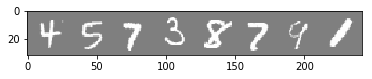

In [58]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
images = images[0:8]
imshow(torchvision.utils.make_grid(images))

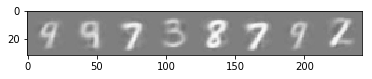

In [59]:
images = images.view(images.shape[0], -1)
images = images.to(device)
outputs = model(images)
outputs = outputs.view(outputs.shape[0],1,28,28).cpu()
imshow(torchvision.utils.make_grid(outputs.detach()))
#blurry bc havent learned enough

## Code Interpolation
Try to interpolate two images and then try to interpolate the codes of the the two images and decode the resulting code. What can you say about latent space interpolation?

In [65]:
data = iter(train_dataloader)

In [67]:
images, _ = data.next()

In [77]:
model.encoder

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU(inplace)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU(inplace)
  (4): Linear(in_features=64, out_features=12, bias=True)
  (5): ReLU(inplace)
  (6): Linear(in_features=12, out_features=3, bias=True)
)

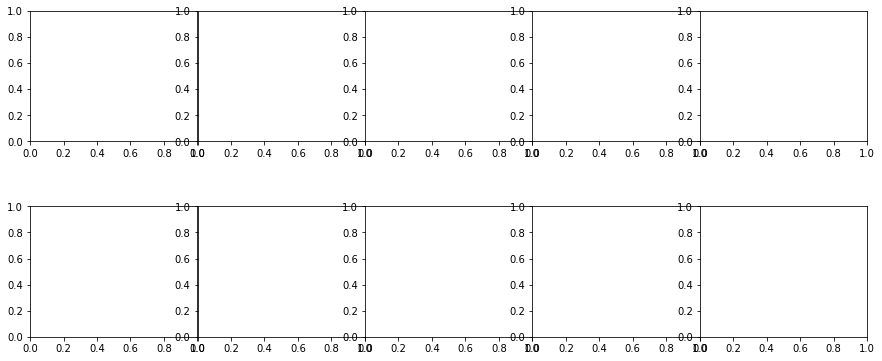

In [82]:
def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        img1 = img1.view(img1.size(0), -1)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        img2 = img2.view(img2.size(0), -1)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), model, images[0], images[5])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
    

plt.show() 

Original images


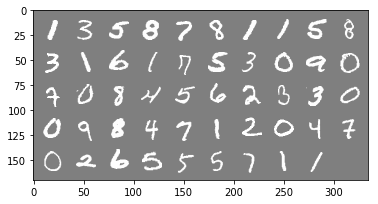

Autoencoder reconstruction:


TypeError: __init__() takes 1 positional argument but 2 were given

In [53]:
#take 2 images and pass them through encoder
#and then take linear interpretation of result and pass through decoder
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():

        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the autoencoder
print('Autoencoder reconstruction:')
visualise_output(images, autoencoder)

AttributeError: type object 'autoencoder' has no attribute 'encoder'

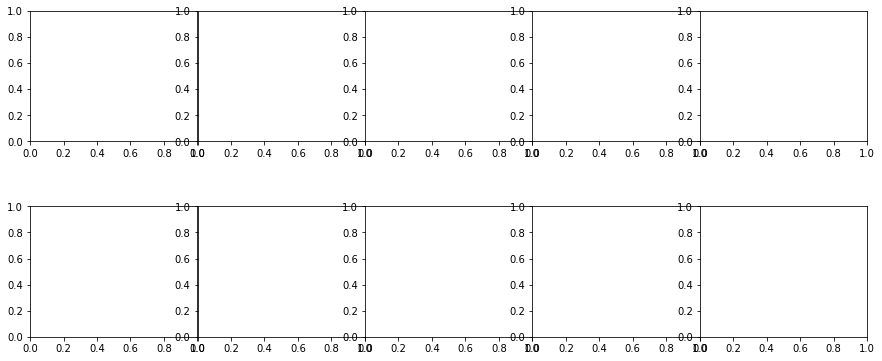

In [84]:
def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():

        # latent vector of first image
        img1 = img1.to(device)
        latent_1 = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2 = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()
    
    return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), autoencoder, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))


plt.show() 

# Convolutional Autoencoder

You should the same functions from the previous section. Make sure you account for the different input dimensions if you don't need to vectorize your image.

# Denoising Autoencoder

In [ ]:
def add_noise(img):
    pass
    return 

In [ ]:
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
images = images[0:8]
images = add_noise(images)
imshow(torchvision.utils.make_grid(images))

In [ ]:
images = images.to(device)
outputs = model(images)
outputs = outputs.view(images.shape[0],1,28,28).cpu()
imshow(torchvision.utils.make_grid(outputs.detach()))